Best model file: BigGRU_Mse_55.05_input_len_60.keras
  → MSE = 55.0500, input sequence length = 60


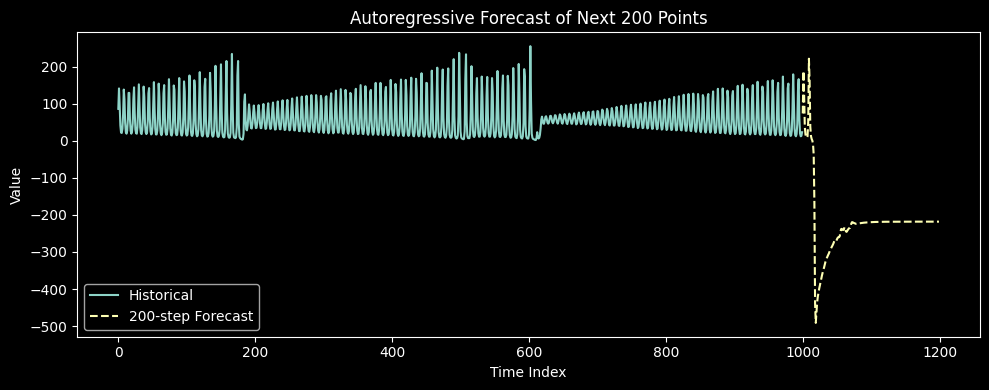

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch" # does not matter chose tensorflow or torch or jax 
import keras
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

#  Locate the best model file by parsing filenames
MODEL_DIR = "cem_models"
pattern = re.compile(r'(?P<model_name>.+?)_Mse_(?P<mse>[0-9]+\.[0-9]+)_input_len_(?P<input_len>\d+)\.keras')

best_mse = float('inf')
best_file = None
best_input_len = None

for fname in os.listdir(MODEL_DIR):
    m = pattern.match(fname)
    if not m:
        continue
    mse = float(m.group('mse'))
    if mse < best_mse:
        best_mse = mse
        best_file = fname
        best_input_len = int(m.group('input_len'))

if best_file is None:
    raise FileNotFoundError(f"No valid .keras files found in '{MODEL_DIR}'")

print(f"Best model file: {best_file}")
print(f"  → MSE = {best_mse:.4f}, input sequence length = {best_input_len}")

#  Load  best model
model_path = os.path.join(MODEL_DIR, best_file)
model = load_model(model_path)

# Load and fit the scaler on your full original series
data_mat = loadmat("Xtrain.mat")
x_raw = data_mat["Xtrain"].flatten()  # shape (N,)

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_raw.reshape(-1, 1)).flatten()

# Autoregressive generation of the next 200 points
n_forecast = 200
lag = best_input_len

# Start with the last lag points of the scaled series
history = list(x_scaled[-lag:])
preds_scaled = []

for _ in range(n_forecast):
    x_input = np.array(history[-lag:]).reshape(1, lag, 1)  # shape (1, lag, 1)
    yhat = model.predict(x_input, verbose=0)[0, 0]
    preds_scaled.append(yhat)
    history.append(yhat)

# Invert the scaling to get predictions in the original range
preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()

#  Plot the historical data plus forecasts
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(x_raw)), x_raw, label="Historical")
plt.plot(np.arange(len(x_raw), len(x_raw) + n_forecast), preds, 
         label=f"{n_forecast}-step Forecast", linestyle="--")
plt.title("Autoregressive Forecast of Next 200 Points")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()
